In [12]:
import pandas as pd
import numpy as np
import glob
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ----------------------------------------
# CONFIG
# ----------------------------------------
RANDOM_SEED = 42
BENIGN_RATIO = 0.975   # 97.5% benign
ATTACK_RATIO = 0.025   # 2.5% attacks (combined)
N_TOTAL = 206_000      # ~200k benign + 6k attacks

# Attack classes of interest (make sure these match your actual filenames!)
ATTACK_CLASSES = [
    "DoS-HTTP_Flood",
    "DDoS-HTTP_Flood",
    "DNS_Spoofing",
    "XSS",
    "DictionaryBruteForce"
]

# ----------------------------------------
# STEP 1: Load packet data
# ----------------------------------------
def load_packet_data(packet_folder="packet_data"):
    benign_files = glob.glob(os.path.join(packet_folder, "BenignTraffic*.csv"))
    benign_dfs = []
    for f in benign_files:
        df = pd.read_csv(f, low_memory=False)
        df['Label'] = 'Benign'
        benign_dfs.append(df)
    benign_df = pd.concat(benign_dfs, axis=0).reset_index(drop=True)

    attack_dfs = []
    for attack in ATTACK_CLASSES:
        f = os.path.join(packet_folder, f"{attack}.csv")
        if os.path.exists(f):
            df = pd.read_csv(f, low_memory=False)
            df['Label'] = attack
            attack_dfs.append(df)
        else:
            print(f"⚠️ Warning: file not found -> {f}")
    attack_df = pd.concat(attack_dfs, axis=0).reset_index(drop=True)

    return benign_df, attack_df

# ----------------------------------------
# STEP 2: Generate sampled dataset
# ----------------------------------------
def generate_dataset(benign_df, attack_df, total_samples=N_TOTAL, random_state=RANDOM_SEED):
    np.random.seed(random_state)
    n_benign = int(total_samples * BENIGN_RATIO)
    n_attack = total_samples - n_benign

    benign_sample = benign_df.sample(n=n_benign, random_state=random_state)

    # random division across attack classes
    attack_subsets = {a: attack_df[attack_df['Label']==a] for a in ATTACK_CLASSES}
    proportions = np.random.dirichlet(np.ones(len(ATTACK_CLASSES)), size=1)[0]
    attack_counts = (proportions * n_attack).astype(int)

    attack_samples = []
    for attack, count in zip(ATTACK_CLASSES, attack_counts):
        available = len(attack_subsets[attack])
        if available > 0:
            count = min(count, available)
            sampled = attack_subsets[attack].sample(n=count, random_state=random_state)
            attack_samples.append(sampled)

    attack_sample = pd.concat(attack_samples, axis=0).reset_index(drop=True)
    dataset = pd.concat([benign_sample, attack_sample], axis=0).sample(frac=1, random_state=random_state).reset_index(drop=True)
    return dataset

# ----------------------------------------
# STEP 3: Preprocess dataset
# ----------------------------------------
def preprocess_dataset(df, drop_columns=['Flow ID', 'Timestamp']):
    df = df.drop(columns=[c for c in drop_columns if c in df.columns], errors='ignore')
    df = df.fillna(0)
    X = df.drop(columns=['Label'])
    y = df['Label']

    X_numeric = X.select_dtypes(include=[np.number])
    X_categorical = pd.get_dummies(X.select_dtypes(exclude=[np.number]), drop_first=True)
    X_combined = pd.concat([X_numeric, X_categorical], axis=1)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_combined)

    return X_scaled, y, scaler, X_combined.columns, X_combined


# ----------------------------------------
# MAIN EXECUTION
# ----------------------------------------
# Main execution
if __name__ == "__main__":
    packet_folder = "packet_data"  # adjust folder name
    # Load packet-level data
    benign_df, attack_df = load_packet_data(packet_folder)
    print("Benign shape:", benign_df.shape)
    print("Attack shape:", attack_df.shape)
    
    # Generate sampled dataset
    dataset = generate_dataset(benign_df, attack_df)
     # Preprocess dataset
    X_scaled, y, scaler, used_features, X_combined = preprocess_dataset(dataset)
    print("Final dataset shape:", dataset.shape)
    print("Label distribution:\n", dataset['Label'].value_counts()) 
    print("✅ Data ready for Phase 2!")
    print("Scaled feature shape:", X.shape)
    print("First 10 features used:", used_features[:10])  # You can print the full list here if you prefer
    
    # Train/test split
     # Split train/test at packet level
    X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
        X_scaled, y, dataset, test_size=0.2, random_state=RANDOM_SEED, stratify=y
    )
    
    print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Benign shape: (1182798, 136)
Attack shape: (914277, 136)
Final dataset shape: (205997, 136)
Label distribution:
 Label
Benign                  200850
DDoS-HTTP_Flood           2636
DNS_Spoofing              1153
XSS                        799
DoS-HTTP_Flood             411
DictionaryBruteForce       148
Name: count, dtype: int64
✅ Data ready for Phase 2!
Scaled feature shape: (205997, 3635)
First 10 features used: Index(['stream', 'src_port', 'dst_port', 'inter_arrival_time',
       'time_since_previously_displayed_frame', 'port_class_dst', 'l4_tcp',
       'l4_udp', 'ttl', 'eth_size'],
      dtype='object')
Train shape: (164797, 3635)  Test shape: (41200, 3635)


Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 55s 78ms/step - loss: 0.5042 - val_loss: 0.4674 - learning_rate: 0.0010
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 28s 49ms/step - loss: 0.4650 - val_loss: 0.4523 - learning_rate: 0.0010
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 28s 49ms/step - loss: 0.4541 - val_loss: 0.4456 - learning_rate: 0.0010
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 29s 50ms/step - loss: 0.4487 - val_loss: 0.4417 - learning_rate: 0.0010
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - loss: 0.4456 - val_loss: 0.4388 - learning_rate: 0.0010
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 29s 50ms/step - loss: 0.4435 - val_loss: 0.4375 - learning_rate: 0.0010
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 0.4422 - val_loss: 0.4366 - learning_rate: 0.0010
Epoch 8/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - loss: 0.4411 - val_loss: 0.4361 - learning_rate: 0.0010
Epoch 9/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - loss: 0.4401 - val_loss: 0.4352 - learning_rate:

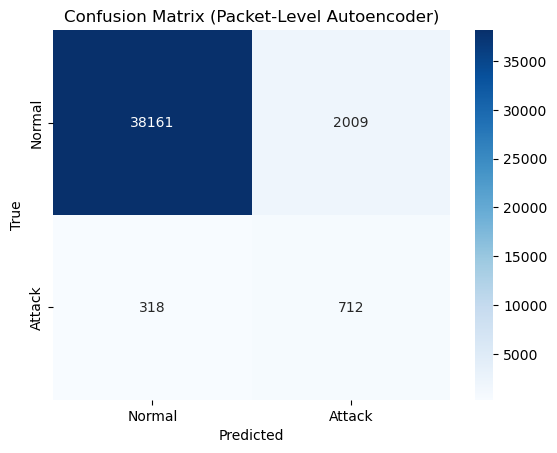

✅ Packet data with predictions saved to packet_test_predictions.csv


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, precision_recall_fscore_support,
    confusion_matrix, accuracy_score
)
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models

# ---------------------------------------------------
# Step 1: Build Autoencoder
# ---------------------------------------------------
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_regularized_autoencoder(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.GaussianNoise(0.01)(inputs)
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    bottleneck = layers.Dense(16, activation="relu", name="bottleneck")(x)
    x = layers.Dense(64, activation="relu")(bottleneck)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(input_dim, activation="linear")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse")
    return model

def train_regularized_autoencoder(X_train, y_train, epochs=50, batch_size=512):
    X_train_benign = X_train[y_train == "Benign"]
    autoencoder = build_regularized_autoencoder(X_train.shape[1])
    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    rl = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
    history = autoencoder.fit(
        X_train_benign, X_train_benign,
        validation_split=0.1,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        callbacks=[es, rl],
        verbose=1
    )
    return autoencoder, history


# ---------------------------------------------------
# Step 3: Test Autoencoder (detect anomalies)
# ---------------------------------------------------
def test_autoencoder(autoencoder, X_test, y_test, threshold=None):
    reconstructions = autoencoder.predict(X_test, verbose=0)
    mse = np.mean(np.square(X_test - reconstructions), axis=1)
    if threshold is None:
        benign_mask = (y_test == "Benign")
        threshold = np.percentile(mse[benign_mask], 95)
    preds = (mse > threshold).astype(int)
    y_binary = (y_test != "Benign").astype(int)
    return preds, mse, threshold, y_binary

# ---------------------------------------------------
# Step 4: Evaluate Model
# ---------------------------------------------------
def evaluate_detector(y_binary, preds, mse, threshold):
    precision, recall, f1, _ = precision_recall_fscore_support(y_binary, preds, average="binary")
    auc = roc_auc_score(y_binary, mse)
    acc = accuracy_score(y_binary, preds)
    print(f"Threshold: {threshold:.5f}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")
    cm = confusion_matrix(y_binary, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal","Attack"],
                yticklabels=["Normal","Attack"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Packet-Level Autoencoder)")
    plt.show()
    return acc, precision, recall, f1, auc
# ----------------------------------------
# STEP 7: Save Packet Test Data with Predictions
# ----------------------------------------
def save_packet_data_with_predictions(packet_df_test, preds, filename="packet_test_predictions.csv"):
    packet_df_test = packet_df_test.copy()
    packet_df_test['Flagged'] = preds
    packet_df_test.to_csv(filename, index=False)
    print(f"✅ Packet data with predictions saved to {filename}")
    return packet_df_test

# ----------------------------------------
# MAIN EXECUTION
# ----------------------------------------
if __name__ == "__main__":
    

    # Train autoencoder
    autoencoder, history = train_regularized_autoencoder(X_train, y_train, epochs=10, batch_size=256)

    # Test autoencoder
    preds, mse, threshold, y_binary = test_autoencoder(autoencoder, X_test, y_test)

    # Evaluate
    evaluate_detector(y_binary, preds, mse, threshold)

    # Save packet-level test data with predictions
    packet_df_test = save_packet_data_with_predictions(df_test, preds)

Flagged suspicious flows shape: (8527, 85)


C:\Users\romib\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\romib\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\romib\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
                       precision    recall  f1-score   support

              Benign       0.99      0.99      0.99       822
     DDoS-HTTP_Flood       0.93      0.83      0.88       124
        DNS_Spoofing       0.93      0.99      0.96       616
DictionaryBruteForce       0.00      0.00      0.00         3
      DoS-HTTP_Flood       1.00      0.90      0.95        84
                 XSS       0.98      0.70      0.82        57

            accuracy                           0.96      1706
           macro avg       0.80      0.74      0.76      1706
        weighted avg       0.96      0.96      0.96      1706



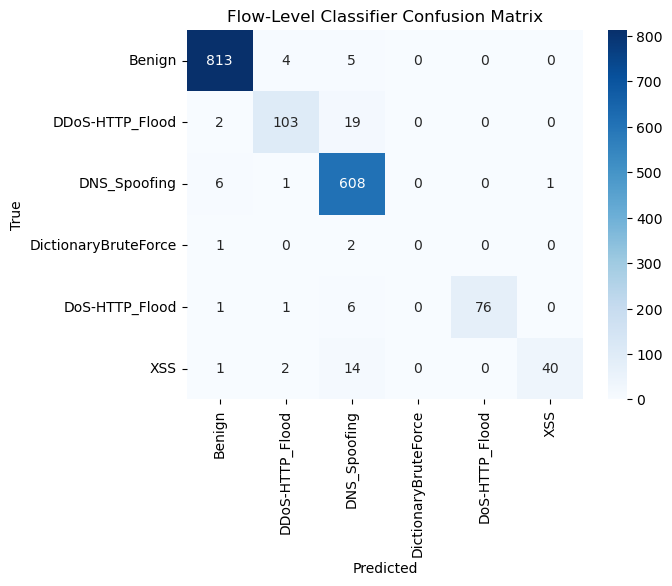

Overall Accuracy: 0.9613130128956624
✅ Phase 3 complete: Signature-based flow-level refinement done!


In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------
# Preprocess flow dataset
# ---------------------------------------------------
def preprocess_flow_dataset(df, flow_id_col=None):
    if flow_id_col:
        df = df.drop(columns=[flow_id_col], errors="ignore")
    
    # Replace inf/-inf with NaN and fill NaN with 0
    df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Split features/labels
    X = df.drop(columns=["label"], errors="ignore")
    y = df["label"]

    # Numeric & categorical separation
    X_numeric = X.select_dtypes(include=[np.number])
    X_categorical = X.select_dtypes(exclude=[np.number])
    if not X_categorical.empty:
        X_categorical = pd.get_dummies(X_categorical, drop_first=True)

    X_combined = pd.concat([X_numeric, X_categorical], axis=1) if not X_categorical.empty else X_numeric

    # Standard scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_combined)

    return X_scaled, y, scaler, X_combined.columns

# ---------------------------------------------------
# Train supervised classifier
# ---------------------------------------------------
def train_signature_classifier(X_train, y_train):
    clf = RandomForestClassifier(
        n_estimators=200, random_state=42, class_weight="balanced_subsample"
    )
    clf.fit(X_train, y_train)
    return clf

# ---------------------------------------------------
# Evaluate classifier
# ---------------------------------------------------
def evaluate_classifier(clf, X_test, y_test):
    preds = clf.predict(X_test)
    print("\nClassification Report:\n", classification_report(y_test, preds))
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=clf.classes_, yticklabels=clf.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Flow-Level Classifier Confusion Matrix")
    plt.show()
    print("Overall Accuracy:", accuracy_score(y_test, preds))

# ---------------------------------------------------
# Map flagged packets to flow-level data
# ---------------------------------------------------
def get_flagged_flows(packet_df, preds, flow_df):
    packet_df = packet_df.copy()
    packet_df["flagged"] = preds
    suspicious_packets = packet_df[packet_df["flagged"] == 1]

    if suspicious_packets.empty:
        return pd.DataFrame()  # No flagged packets

    # Create base Flow ID
    packet_df['flow_base'] = (
        packet_df['src_ip'].astype(str) + '_' +
        packet_df['dst_ip'].astype(str) + '_' +
        packet_df['src_port'].astype(str) + '_' +
        packet_df['dst_port'].astype(str)
    )
    flow_df['flow_base'] = flow_df['flow id'].str.replace('-', '_').str.rsplit('_', n=1).str[0]

    suspicious_flows = flow_df.merge(
        suspicious_packets[['flow_base']].drop_duplicates(),
        on='flow_base',
        how='inner'
    )
    return suspicious_flows

# ---------------------------------------------------
# MAIN EXECUTION: Phase 3
# ---------------------------------------------------
if __name__ == "__main__":
    # flow_dataset: flow-level dataset loaded from Phase 1/2
    # packet_df_test: packet-level test data
    # preds: anomaly predictions from Phase 2 (1=suspicious, 0=benign)

    # Map suspicious packets to flow-level
    suspicious_flows = get_flagged_flows(packet_df_test, preds, flow_dataset)

    if suspicious_flows.empty:
        print("⚠️ No suspicious flows found. Exiting Phase 3.")
    else:
        print("Flagged suspicious flows shape:", suspicious_flows.shape)

        # Preprocess flows
        X_flow, y_flow, scaler, flow_features = preprocess_flow_dataset(suspicious_flows, flow_id_col='flow id')

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_flow, y_flow, test_size=0.2, random_state=42, stratify=y_flow
        )

        # Train classifier
        clf = train_signature_classifier(X_train, y_train)

        # Evaluate classifier
        evaluate_classifier(clf, X_test, y_test)

        print("✅ Phase 3 complete: Signature-based flow-level refinement done!")
